# Task 2

Task 2: You are free to find and define a problem (apply the discovery and define phases first, from the UK Design Council Double Diamond, 3.007 Design Thinking and Innovation) of your interest related to COVID-19. The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression, which means you can work with either continuous numerical data or classification.

The following technical/tool constraint applies: you are NOT allowed to use Neural Networks or other Machine Learning models. You must use Python and Jupyter Notebook.

In general, you may want to consider performing the following steps:
- Find an interesting problem which you want to solve either using **Linear Regression or Classification** (please check with your instructors first on whether the problem makes sense).
- Find a **dataset** to build your model. For example, you can use Kaggle (https://www.kaggle.com/datasets) to find suitable datasets.
- Use **plots** to visualize and understand your data.
- Create **training and test** data sets.
- Build your model.
- Choose an **appropriate metric** to evaluate your model (you may use the same metric as the one used in Task 1).
- Improve your model.

Problem: predict gold prices given covid
Effect of covid on economy

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load data 
We use data from [Yahoo Finance](https://finance.yahoo.com/quote/GLD/history?period1=1479859200&period2=1637625600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) 

In [13]:
df_gold_all = pd.read_csv('GLD.csv')
df = pd.read_csv('covid_data.csv')

# display(df_gold)
# display(df)


## Clean data

In [14]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set

df_subset = df.loc[((df['location']=='United States')| (df['location']=='China') | (df['location']=='Japan') | (df['location']=='Hong Kong') | (df['location']=='United Kingdom') | 
(df['location']=='Canada') | (df['location']=='India') | (df['location']=='Saudi Arabia') | (df['location']=='France') | (df['location']=='Germany') | 
(df['location']=='South Korea') | (df['location']=='Switzerland') | (df['location']=='Australia') | (df['location']=='Netherlands') |  
(df['location']=='Iran')| (df['location']=='Sweden')| (df['location']=='Brazil')| (df['location']=='Spain')|(df['location']=='Russia') |(df['location']=='Singapore')) ,:]

# & ((df['date']> '2021-01-01') & (df['date']< '2021-11-17'))
#'population_density','handwashing_facilities','extreme_poverty','gdp_per_capita',
# (df['location']=='Bulgaria') | (df['location']=='Croatia') | (df['location']=='Cyprus') | (df['location']=='Czech Republic') | 
# (df['location']=='Latvia') | (df['location']=='Lithuania') | (df['location']=='Luxembourg') | 
# (df['location']=='Malta') | 
# (df['location']=='Romania')| 
# (df['location']=='Slovakia')|

In [15]:
df_covid=df_subset.fillna(0)
# display(df_covid.index)

In [16]:
df_covid['Week']=pd.to_datetime(df_covid['date'])
# print(df_covid)
df_covid=df_covid.groupby(pd.Grouper(key='Week', freq="W-MON")).mean()
df_covid=df_covid.iloc[:95,:]
# display(df_covid)

# print(df_covid.index)
# print(df_covid.shape)

In [17]:
# Clean Up of Gold Data frame
# change to standard date 

df_gold_all = pd.read_csv('GLD.csv')

# change gold date range to same range as covid date range
df_gold=df_gold_all.copy()
df_gold=df_gold.loc[((df_gold['Date']> '2020-01-26') & (df_gold['Date']< '2021-11-17')) ,:]

# change the date column to DateTime Index
df_gold['Date'] = pd.to_datetime(df_gold['Date']).dt.date

# pd.set_option('display.max_rows', None)
# display(df_gold)
# print(pd.options.display.max_rows)
# pd.reset_option('display.max_rows')
# print(pd.options.display.max_rows)
# display(df_gold)
# print(df_gold.shape)

    

In [18]:
df_covid=df_covid.reset_index()
# display(df_covid)
df_gold=df_gold.reset_index()
# display(df_gold)
frames=[df_gold,df_covid]
df_all = pd.concat(frames,axis=1)
# display(df_all)
df_all.drop(['index','Week'], axis=1, inplace=True)
# display(df_all)

In [19]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set
columns_cat=['Date']
columns_num=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cat = df_all.loc[:,columns_cat]

df_num = df_all.loc[:,columns_num]

# display(df_num)

def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

df_num_norm = normalize_z(df_num)
stats = df_num_norm.describe()
# display(stats)

frames=[df_cat , df_num_norm]
result = pd.concat(frames,axis=1)
df_covid=result.fillna(0)
# display(df_covid.index)

In [20]:
def r2_score(y, ypred):
    # calculate ssres
    diff = y - ypred
    ssres = np.matmul(diff.T, diff)[0][0]
    
    # calculate sstot
    ymean=np.mean(y)
    diff_mean=y-ymean #element wise subtraction
    sstot= np.matmul(diff_mean.T, diff_mean)[0][0]
    
    # calcuate r2
    return 1-(ssres/sstot)

In [21]:
display(df_covid)

,Date,new_deaths,new_cases,stringency_index,total_tests,total_vaccinations,reproduction_rate,hospital_beds_per_thousand,hosp_patients_per_million,hosp_patients,icu_patients_per_million,icu_patients,Open,High,Low,Close,Adj Close,Volume
0,2020-01-27,-2.029442,-1.599602,-3.397725,-1.146322,-0.625988,-2.266703,8.221113,-1.347272,-1.340580,-1.442395,-1.439997,-1.926076,-2.212200,-1.850931,-1.964620,-1.964620,-0.187624
1,2020-02-03,-2.006215,-1.580816,-3.211582,-1.146321,-0.625988,-2.846634,3.427106,-1.347160,-1.340493,-1.442159,-1.439830,-1.985230,-2.307078,-2.028983,-2.125086,-2.125086,-0.590040
2,2020-02-10,-1.989245,-1.577233,-2.970601,-1.146319,-0.625988,-3.256567,2.169157,-1.347055,-1.340411,-1.442262,-1.439902,-2.031125,-2.270180,-1.904450,-1.999005,-1.999005,-0.953674
3,2020-02-17,-1.964394,-1.567463,-2.938939,-1.146308,-0.625988,-3.374672,2.169157,-1.347169,-1.340500,-1.442350,-1.439966,-1.860803,-1.628167,-1.651265,-1.405076,-1.405076,-0.224015
4,2020-02-24,-1.977671,-1.599782,-2.922941,-1.146286,-0.625988,-2.778933,1.296447,-1.347263,-1.340574,-1.442395,-1.439997,-0.981654,-1.279223,-1.900332,-2.063608,-2.063608,3.950812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2021-10-18,-0.172692,-0.039062,-0.348146,1.732545,2.229465,-0.111277,-0.197709,-0.483991,-0.000031,-0.313993,0.346906,-0.275887,-0.118538,-0.072467,-0.043203,-0.043203,-0.855199
91,2021-10-25,-0.156986,-0.036934,-0.418922,1.834194,2.316405,0.064241,-0.197709,-0.476222,-0.088254,-0.338020,0.227938,0.054559,-0.149110,0.012957,-0.159907,-0.159907,-0.806733
92,2021-11-01,-0.184489,0.000449,-0.765111,1.818474,2.300448,0.201485,-0.197709,-0.458501,-0.149214,-0.349454,0.078821,-0.075987,-0.076369,-0.116722,0.172486,0.172486,-0.725182
93,2021-11-08,-0.320050,0.030864,-1.215295,1.907338,2.308341,0.192189,-0.197709,-0.471427,-0.210496,-0.387814,-0.065603,0.235080,0.422272,0.467865,0.652840,0.652840,-0.629565


### Visualising data

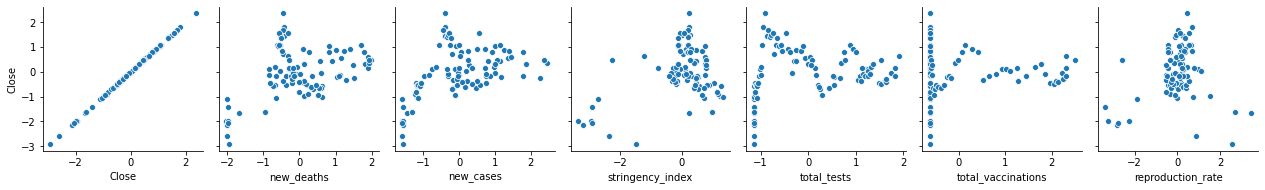

In [22]:
myplot = sns.pairplot(data=df_covid, x_vars=['Close','new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate'],y_vars=['Close'])

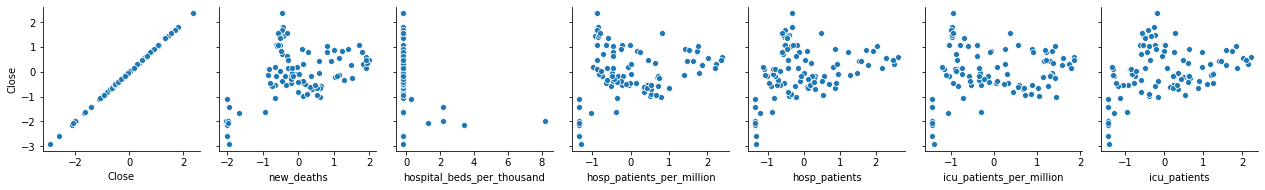

In [23]:
myplot = sns.pairplot(data=df_covid, x_vars=['Close','new_deaths','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients'],y_vars=['Close'])

### Train model

In [24]:
def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

def get_features_targets(df, feature_names, target_names):
    df_feature=df.loc[:,feature_names]
    df_target=df.loc[:,target_names]
    return df_feature, df_target

def compute_cost(X, y, beta):
    J = 0
    #calculate m, no of rows/data pt
    m = X.shape[0]
    
    #calculate yp, predicted target value from X and beta
    yp = np.matmul(X, beta)
    
    #calculate the error
    error = yp-y
    
    #calculate the cost
    J = (1/(2*m))*np.matmul(error.T, error)
    J= J[0][0] #to get the float
    return J

def prepare_feature(df_feature):
    #numpy is just arrays
    feature = df_feature.to_numpy()
    array1 = np.ones((feature.shape[0],1))
    X = np.concatenate((array1, feature), axis = 1)
    return X

def prepare_target(df_target):
    return df_target.to_numpy() 

def gradient_descent(X, y, beta, alpha, num_iters):
    #calculate m from shape of X or y
    m = X.shape[0]
    J_storage = np.zeros(num_iters)

    #for the number of iterations
    for n in range(num_iters):
        #--> compute the predicted y
        yp = np.matmul(X, beta)
        
        #--> compute the error
        error = yp - y
        
        #--> compute the new beta
        beta = beta - (alpha/m)*np.matmul(X.T, error)
        
        #--> compute J using the new beta and store it
        J_storage[n] = compute_cost(X, y, beta)
        
    return beta, J_storage

def predict_norm(X, beta):
    y = np.matmul(X, beta)
    return y

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    X = prepare_feature(df_feature)
    yp = predict_norm(X, beta)
    return yp

def mean_squared_error(target, pred):
    n=target.shape[0]
    error=target-pred
    mse=(1/n)*np.sum(error**2)
    return mse

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indices=df_target.index

    if random_state!=None:
        np.random.seed(random_state)
    
    num_rows=len(indices)
    k = int(test_size * num_rows)
    test_indices=np.random.choice(indices,k,replace=False)

    indices=set(indices)
    test_indices=set(test_indices)
    train_indices=indices-test_indices
    
    df_feature_train=df_feature.loc[train_indices,:]
    df_feature_test=df_feature.loc[test_indices,:]
    df_target_train=df_target.loc[train_indices,:]
    df_target_test=df_target.loc[test_indices,:]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

In [25]:
# features=['new_deaths', 'new_cases',
#          'stringency_index','total_tests','total_vaccinations',
#          'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients']

features=['hosp_patients_per_million','hosp_patients','icu_patients_per_million','icu_patients']

df_feature, df_target = get_features_targets(df_covid, features, ['Close'])

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

X = prepare_feature(df_features_train)
# print(X)
m=X.shape[1]
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((m,1))

# call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)



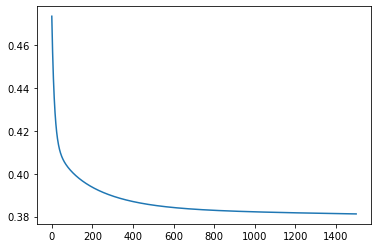

In [26]:
plt.plot(J_storage)

In [27]:
# call the predict method to get the predicted values
target = prepare_target(df_target_test)
pred = predict(df_features_test, beta)
with np.printoptions(threshold=np.inf):
    print(beta)

[[-0.09369682]
 [-0.077568  ]
 [ 0.1558163 ]
 [-0.19738841]
 [ 0.46409977]]


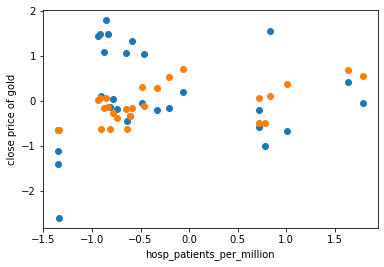

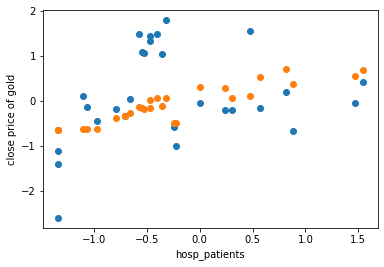

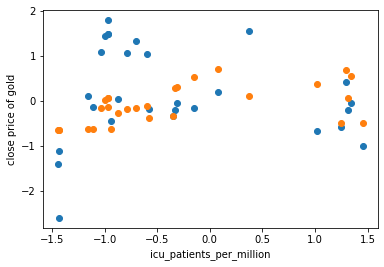

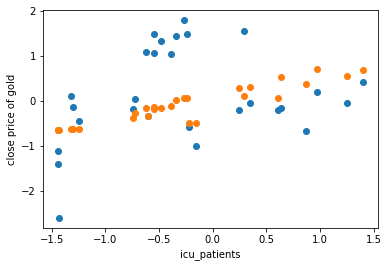

In [28]:
# features=['new_deaths', 'new_cases',
#          'stringency_index','total_tests','total_vaccinations',
#          'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients']

features=['hosp_patients_per_million','hosp_patients','icu_patients_per_million','icu_patients']

for i in range(len(features)):
    ft=features[i]
    plt.figure(i)
    plt.scatter(df_features_test[ft],target)
    plt.scatter(df_features_test[ft],pred)
    plt.xlabel(ft)
    plt.ylabel('close price of gold')

In [29]:
mse1=mean_squared_error(target,pred)
print(mse1)
# yes still meaningful, minimum mse with coeff
# if model is bad then mse may be big

0.962324820077845


In [30]:
#r_2
r_2 = r2_score(target,pred)
print("r_2",r_2)
#adj_r_2
X, y = df_features_test, df_target_test
manual_adj_r_2 = 1 - (1-r_2)*(len(y)-1)/(len(y)-X.shape[1]-1)
print("manual_adj_r_2",manual_adj_r_2)

r_2 0.07968520154220693
manual_adj_r_2 -0.08036954601567015


# Add polynomial regression

In [31]:
def transform_features(df_feature, colname, colname_transformed,power):
    df_out=df_feature.copy()
    for i in range(1,power):
        df_out.loc[:,colname_transformed+str(i)]=df_feature[colname]**i 
    return df_out

In [32]:
display(df_covid)

,Date,new_deaths,new_cases,stringency_index,total_tests,total_vaccinations,reproduction_rate,hospital_beds_per_thousand,hosp_patients_per_million,hosp_patients,icu_patients_per_million,icu_patients,Open,High,Low,Close,Adj Close,Volume
0,2020-01-27,-2.029442,-1.599602,-3.397725,-1.146322,-0.625988,-2.266703,8.221113,-1.347272,-1.340580,-1.442395,-1.439997,-1.926076,-2.212200,-1.850931,-1.964620,-1.964620,-0.187624
1,2020-02-03,-2.006215,-1.580816,-3.211582,-1.146321,-0.625988,-2.846634,3.427106,-1.347160,-1.340493,-1.442159,-1.439830,-1.985230,-2.307078,-2.028983,-2.125086,-2.125086,-0.590040
2,2020-02-10,-1.989245,-1.577233,-2.970601,-1.146319,-0.625988,-3.256567,2.169157,-1.347055,-1.340411,-1.442262,-1.439902,-2.031125,-2.270180,-1.904450,-1.999005,-1.999005,-0.953674
3,2020-02-17,-1.964394,-1.567463,-2.938939,-1.146308,-0.625988,-3.374672,2.169157,-1.347169,-1.340500,-1.442350,-1.439966,-1.860803,-1.628167,-1.651265,-1.405076,-1.405076,-0.224015
4,2020-02-24,-1.977671,-1.599782,-2.922941,-1.146286,-0.625988,-2.778933,1.296447,-1.347263,-1.340574,-1.442395,-1.439997,-0.981654,-1.279223,-1.900332,-2.063608,-2.063608,3.950812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2021-10-18,-0.172692,-0.039062,-0.348146,1.732545,2.229465,-0.111277,-0.197709,-0.483991,-0.000031,-0.313993,0.346906,-0.275887,-0.118538,-0.072467,-0.043203,-0.043203,-0.855199
91,2021-10-25,-0.156986,-0.036934,-0.418922,1.834194,2.316405,0.064241,-0.197709,-0.476222,-0.088254,-0.338020,0.227938,0.054559,-0.149110,0.012957,-0.159907,-0.159907,-0.806733
92,2021-11-01,-0.184489,0.000449,-0.765111,1.818474,2.300448,0.201485,-0.197709,-0.458501,-0.149214,-0.349454,0.078821,-0.075987,-0.076369,-0.116722,0.172486,0.172486,-0.725182
93,2021-11-08,-0.320050,0.030864,-1.215295,1.907338,2.308341,0.192189,-0.197709,-0.471427,-0.210496,-0.387814,-0.065603,0.235080,0.422272,0.467865,0.652840,0.652840,-0.629565


In [33]:
features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']

all={}
mse_all=[]
for i in range(1,5):
    df_feature, df_target = get_features_targets(df_covid, features, ['Close'])
    df_feature = transform_features(df_feature, "hosp_patients", "hosp_patients^",i)
    df_feature = transform_features(df_feature, "hosp_patients_per_million", "hosp_patients_per_million^",i)
    df_feature = transform_features(df_feature, "icu_patients", "icu_patients^",i)
    df_feature = transform_features(df_feature, "icu_patients_per_million", "icu_patients_per_million^",i)
    
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
    
    X = prepare_feature(df_features_train)
    # print(X)
    m=X.shape[1]
    target = prepare_target(df_target_train)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((m,1))

    # call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # call the predict method to get the predicted values
    pred = predict(df_features_test, beta)
    print(pred.shape)
    all[i]=pred

    #collect evaluation metric
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    print(mse2)
    mse_all.append(mse2)


# print(all)
print(df_feature)


(28, 1)
0.4742568992370234
(28, 1)
0.47436176552988196
(28, 1)
0.494415292040889
(28, 1)
0.3417216779042792
    new_deaths  new_cases  stringency_index  total_tests  total_vaccinations  \
0    -2.029442  -1.599602         -3.397725    -1.146322           -0.625988   
1    -2.006215  -1.580816         -3.211582    -1.146321           -0.625988   
2    -1.989245  -1.577233         -2.970601    -1.146319           -0.625988   
3    -1.964394  -1.567463         -2.938939    -1.146308           -0.625988   
4    -1.977671  -1.599782         -2.922941    -1.146286           -0.625988   
..         ...        ...               ...          ...                 ...   
90   -0.172692  -0.039062         -0.348146     1.732545            2.229465   
91   -0.156986  -0.036934         -0.418922     1.834194            2.316405   
92   -0.184489   0.000449         -0.765111     1.818474            2.300448   
93   -0.320050   0.030864         -1.215295     1.907338            2.308341   
94   -0.2909

Text(0, 0.5, 'Mean squared error')

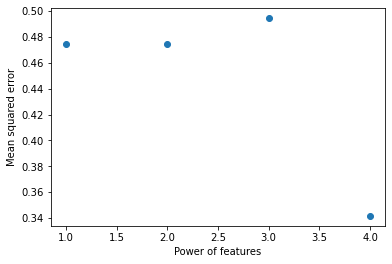

In [34]:
power=list(range(1,5))
plt.figure(6)
plt.scatter(power,mse_all)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')

In [35]:
# ERROR
# features=['hospital_beds_per_thousand','hosp_patients_per_million',
#          'hosp_patients','icu_patients_per_million','icu_patients']

# for power in range(2,5):
#     pred=all[power]
#     df_feature, df_target = get_features_targets(df_covid, features, ['Close'])
#     df_feature = transform_features(df_feature, "hosp_patients", "hosp_patients^",i)
#     df_feature = transform_features(df_feature, "hosp_patients_per_million", "hosp_patients_per_million^",i)
#     df_feature = transform_features(df_feature, "icu_patients", "icu_patients^",i)
#     df_feature = transform_features(df_feature, "icu_patients_per_million", "icu_patients_per_million^",i)
    

#     for x in range(len(features)):
#         ft=features[x]
#         plt.figure(x)
#         plt.scatter(df_feature[ft+'^'+str(power)],target)
#         plt.scatter(df_feature[ft+'^'+str(power)],pred)
#         plt.xlabel(ft+str(power))
#         plt.ylabel('close price of gold')
        